# Ptychography Reconstruction

This notebook demonstrates a simulated ptychographic reconstruction using tike.

In [1]:
import logging

import matplotlib.pyplot as plt
import numpy as np

import tike
import tike.ptycho
import tike.view

In [2]:
for module in [tike, np]:
    print("{} is version {}".format(module.__name__, module.__version__))

tike is version 0.17.1.dev144+g0b989e3
numpy is version 1.20.3


## Load experimental data

This data is a real dataset that has been pre-processed to be smaller so that it can be used as a test dataset. It contains the diffraction patterns, scan positions in pixel units, and an initial probe guess. There are functions in the `tike.ptycho.io` module which may do this pre-processing automatically from select on-disk formats.

In [3]:
import bz2

with bz2.open('../../../tests/data/siemens-star-small.npz.bz2') as f:
    archive = np.load(f)
    scan = archive['scan']
    data = archive['data']
    probe = archive['probe']

### The probe

Note that the shape of the probe includes many dimensions. These leading dimensions are for providing multiple probes and to make internal multiplcations easier. This initial probe guess was generated from an analytical function which models the Freznel zone plate and other optics at the Velociprobe. Read the documentation of the `tike.ptycho.probe` module for more information.

In [4]:
probe.shape, probe.dtype

((1, 1, 1, 1, 128, 128), dtype('complex64'))

(-0.22053738-0.014846489j) (0.21158107+0.0107072005j)


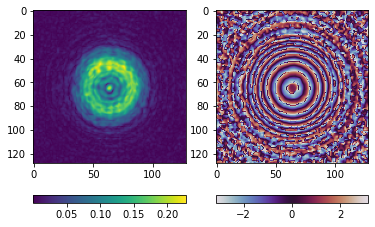

In [5]:
for m in range(probe.shape[-3]):
    plt.figure()
    tike.view.plot_phase(probe[0, 0, 0, m])
    plt.show()

### Define the trajectory

The scanning positions must be scaled so that one scanning unit is the width of one pixel in the initial probe/object array; i.e. pixel units. All dimensions are consistently ordered; the `scan[..., 0]` coordinates correspond to `probe.shape[-2]` and `data.shape[-2]`.

If you provide an initial object (`psi`), then you need to make it large enough to contain all of the scan positions plus the 2 pixel buffer along each edge plus the width of the probe in each dimension. If you do not provide an initial guess of the object, then tike does this shifting of the scanning positions automatically and will choose a conservatively large field of view. 

In [6]:
scan.shape, scan.dtype

((1, 516, 2), dtype('float32'))

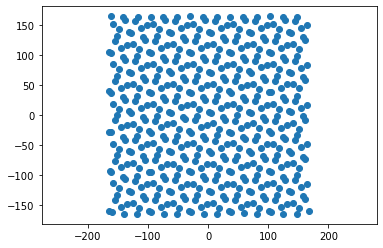

In [7]:
plt.figure()
plt.scatter(scan[0, :, 0], scan[0, :, 1])
plt.axis('equal')
plt.show()

### Diffraction patterns

The diffraction patterns should be cropped to a square shape that is larger than or equal to the shape of the probe array. Preferably, these arrays should be shaped to powers of 2 (for computational efficiency). The diffraction patterns should also be FFT shifted such that the zero-frequency (center of diffraction pattern) is at the origin.

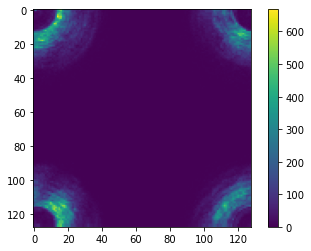

(0.0, 963.0, dtype('float32'))

In [8]:
plt.figure()
plt.imshow((data[0, 11]))
plt.colorbar()
plt.show()
np.min(data), np.max(data), data.dtype

## Reconstruct

Now we try and reconstruct the object (`psi`). To indicate which parameters we want to reconstruct, we use the Options classes. Providing no or `None` Option indicates that a parameter will not be updated. Providing an empty Option indicates that the default options will be used.

In [9]:
object_options = tike.ptycho.ObjectOptions(
    # The object will be updated.
    smoothness_constraint=0.03,  # smoothness constraint will use our provided setting
    # other object options will be default values
)
position_options = None # indicates that positions will not be updated

In [10]:
# Provide initial guesses for parameters that are updated
result = {
    # initial guess for psi can be automatically generated
    'probe': probe,
    'scan': scan,
}

In [11]:
logging.basicConfig(level=logging.INFO)

result = tike.ptycho.reconstruct(
    data=data,
    **result,
    algorithm='lstsq_grad',
    num_iter=128,
    recover_probe=True,
    object_options=object_options,
    position_options=position_options,
)

INFO:tike.ptycho.ptycho:lstsq_grad for 516 - 128 by 128 frames for 128 iterations.
INFO:tike.ptycho.ptycho:object and probe rescaled by 94.335566
INFO:tike.ptycho.ptycho:lstsq_grad epoch 0
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.60928e+00
INFO:tike.ptycho.solvers.divided:  farplane cost is +1.40232e+00
INFO:tike.ptycho.solvers.divided: nearplane cost is +3.44319e+03
INFO:tike.ptycho.solvers.divided: nearplane cost is +3.44319e+03
INFO:tike.ptycho.object:Object smooth constrained with kernel param 0.000e+00
INFO:tike.ptycho.ptycho:lstsq_grad epoch 1
INFO:tike.ptycho.solvers.divided:  farplane cost is +3.73698e+00
INFO:tike.ptycho.solvers.divided:  farplane cost is +9.34245e-01
INFO:tike.ptycho.solvers.divided: nearplane cost is +2.81039e+03
INFO:tike.ptycho.solvers.divided: nearplane cost is +2.81039e+03
INFO:tike.ptycho.object:Object smooth constrained with kernel param 0.000e+00
INFO:tike.ptycho.ptycho:lstsq_grad epoch 2
INFO:tike.ptycho.solvers.divided:  farplane cost 

INFO:tike.ptycho.solvers.divided:  farplane cost is +1.01938e+00
INFO:tike.ptycho.solvers.divided:  farplane cost is +2.54845e-01
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.46782e+03
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.46782e+03
INFO:tike.ptycho.object:Object smooth constrained with kernel param 0.000e+00
INFO:tike.ptycho.ptycho:lstsq_grad epoch 22
INFO:tike.ptycho.solvers.divided:  farplane cost is +1.00937e+00
INFO:tike.ptycho.solvers.divided:  farplane cost is +2.52343e-01
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.46060e+03
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.46060e+03
INFO:tike.ptycho.object:Object smooth constrained with kernel param 0.000e+00
INFO:tike.ptycho.ptycho:lstsq_grad epoch 23
INFO:tike.ptycho.solvers.divided:  farplane cost is +1.00023e+00
INFO:tike.ptycho.solvers.divided:  farplane cost is +2.50057e-01
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.45397e+03
INFO:tike.ptycho.solvers.divided: nearpla

INFO:tike.ptycho.solvers.divided: nearplane cost is +1.38582e+03
INFO:tike.ptycho.object:Object smooth constrained with kernel param 0.000e+00
INFO:tike.ptycho.ptycho:lstsq_grad epoch 43
INFO:tike.ptycho.solvers.divided:  farplane cost is +9.06039e-01
INFO:tike.ptycho.solvers.divided:  farplane cost is +2.26510e-01
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.38382e+03
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.38382e+03
INFO:tike.ptycho.object:Object smooth constrained with kernel param 0.000e+00
INFO:tike.ptycho.ptycho:lstsq_grad epoch 44
INFO:tike.ptycho.solvers.divided:  farplane cost is +9.03531e-01
INFO:tike.ptycho.solvers.divided:  farplane cost is +2.25883e-01
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.38190e+03
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.38190e+03
INFO:tike.ptycho.object:Object smooth constrained with kernel param 0.000e+00
INFO:tike.ptycho.ptycho:lstsq_grad epoch 45
INFO:tike.ptycho.solvers.divided:  farplane cost 

INFO:tike.ptycho.solvers.divided:  farplane cost is +8.69004e-01
INFO:tike.ptycho.solvers.divided:  farplane cost is +2.17251e-01
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.35524e+03
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.35524e+03
INFO:tike.ptycho.object:Object smooth constrained with kernel param 0.000e+00
INFO:tike.ptycho.ptycho:lstsq_grad epoch 65
INFO:tike.ptycho.solvers.divided:  farplane cost is +8.67796e-01
INFO:tike.ptycho.solvers.divided:  farplane cost is +2.16949e-01
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.35430e+03
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.35430e+03
INFO:tike.ptycho.object:Object smooth constrained with kernel param 0.000e+00
INFO:tike.ptycho.ptycho:lstsq_grad epoch 66
INFO:tike.ptycho.solvers.divided:  farplane cost is +8.66621e-01
INFO:tike.ptycho.solvers.divided:  farplane cost is +2.16655e-01
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.35338e+03
INFO:tike.ptycho.solvers.divided: nearpla

INFO:tike.ptycho.solvers.divided: nearplane cost is +1.33961e+03
INFO:tike.ptycho.object:Object smooth constrained with kernel param 0.000e+00
INFO:tike.ptycho.ptycho:lstsq_grad epoch 86
INFO:tike.ptycho.solvers.divided:  farplane cost is +8.48345e-01
INFO:tike.ptycho.solvers.divided:  farplane cost is +2.12086e-01
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.33903e+03
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.33903e+03
INFO:tike.ptycho.object:Object smooth constrained with kernel param 0.000e+00
INFO:tike.ptycho.ptycho:lstsq_grad epoch 87
INFO:tike.ptycho.solvers.divided:  farplane cost is +8.47627e-01
INFO:tike.ptycho.solvers.divided:  farplane cost is +2.11907e-01
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.33847e+03
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.33847e+03
INFO:tike.ptycho.object:Object smooth constrained with kernel param 0.000e+00
INFO:tike.ptycho.ptycho:lstsq_grad epoch 88
INFO:tike.ptycho.solvers.divided:  farplane cost 

INFO:tike.ptycho.solvers.divided:  farplane cost is +8.35752e-01
INFO:tike.ptycho.solvers.divided:  farplane cost is +2.08938e-01
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.32906e+03
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.32906e+03
INFO:tike.ptycho.object:Object smooth constrained with kernel param 0.000e+00
INFO:tike.ptycho.ptycho:lstsq_grad epoch 108
INFO:tike.ptycho.solvers.divided:  farplane cost is +8.35257e-01
INFO:tike.ptycho.solvers.divided:  farplane cost is +2.08814e-01
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.32866e+03
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.32866e+03
INFO:tike.ptycho.object:Object smooth constrained with kernel param 0.000e+00
INFO:tike.ptycho.ptycho:lstsq_grad epoch 109
INFO:tike.ptycho.solvers.divided:  farplane cost is +8.34770e-01
INFO:tike.ptycho.solvers.divided:  farplane cost is +2.08692e-01
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.32828e+03
INFO:tike.ptycho.solvers.divided: nearp

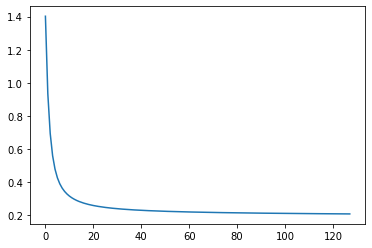

In [12]:
plt.figure()
plt.plot(result['cost'])
plt.show()

(0.5280064-0.19035421j) (1.4874094+0.031986464j)


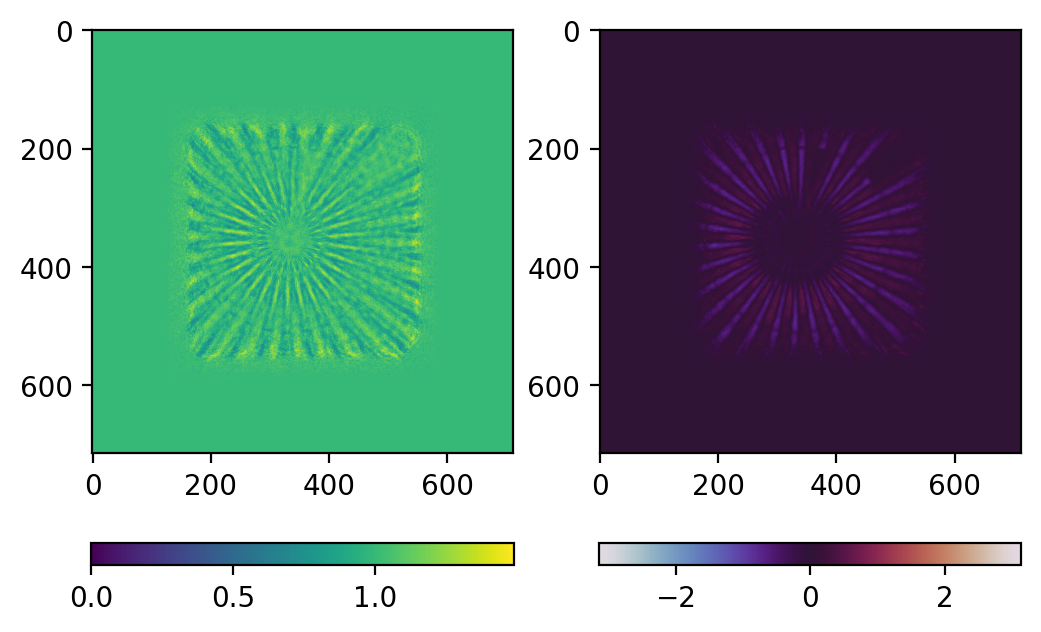

In [13]:
for v in [0]:
    plt.figure(dpi=200)
    tike.view.plot_phase(result['psi'][v], amin=0)
    plt.show()